### Note: The overall time to run this program is about two and a half hours, which means this program is so inefficient. Downloading data from the website and store into database takes about half an hour; calculate the difference, clean data and store into databse takes about two hours. After these, pulling data from database to do data analysis and visualization basically takes no more than one or two minutes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlite3
import urllib
import re
from lxml import etree
from datetime import datetime
from bs4 import BeautifulSoup

# Data Analysis

##### Q1: Which station has the most number of units?
A: 34 ST-PENN STA has the most number of units which is 14.<br>

##### Q2: What is the total number of entries & exits across the subway system for February 1, 2013?
A:The toal number of entries is 5812068, toal number of exits is 4497741.<br>

##### Q3: Let’s define the busyness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
A:The busiest station was 34 ST-PENN STA. The business turnstile was R319 in Control Area N601.<br>


##### Q4:What stations have seen the most usage growth/decline in 2013?
A: I calculated the usage monthly and calculated the monthly growth.<br>
In terms of absolute value : most Total growth is 34 ST-HERALD SQ; most Total decline is JOURNAL SQUARE.<br>
In terms of percentage growth : most Total growth is SOUTH FERRY; most Total decline is CASTLE HILL AVE.<br>


##### Q5:What dates are the least busy? 
A:The least busy dates are 2013-12-15 (Christmas), 2013-11-28 (Thanksgiving), 2013-02-03, 2013-02-09 and 2013-01-06<br>

##### Q6:Could you identify days on which stations were not operating at full capacity or closed entirely?
A: Table are shown below.<br>

##### Q7:Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?
A: The busiest hour is around  6:00pm.<br>

### Details are shown below

### -  Which station has the most number of units?

#### A:We can see that 34 ST-PENN STA has the most number of units which is 14.

In [2]:
station_units = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')

In [3]:
station_units = station_units[['Station','Booth','Remote']].drop_duplicates()
# notice that this R101S has no 'S' in the .txt file.
station_units = station_units.replace('R101S','R101')
station_units.columns=['Station','CA','Unit']
unit_count = station_units.groupby('Station').count()['Unit']

In [4]:
print(unit_count.idxmax())
print(unit_count.max())

34 ST-PENN STA
14


## Loading dataset

In [5]:
#define a function to convert rawdata to a format easier to handle
def structdata(url):
    
    col_len = []
    with urllib.request.urlopen(url) as req:
        for line in req:
            line = line.decode('utf-8').strip()
            parts = line.split(',')
            col_len.append(len(parts))
    
    rawdata = pd.read_table(url,sep=',',header=None, names=range(max(col_len)),index_col=[0,1,2]) #first three columns as index
    
    #reshape the data to five columns
    rep_num = len(rawdata.columns)//5
    index = pd.MultiIndex.from_tuples(rawdata.index.ravel().repeat(rep_num), names=['CA','Unit','SCP'])    
    data = pd.DataFrame(rawdata.values.reshape(-1,5),index= index, columns=['Date','Time','Desc','Entries','Exits']).dropna()
    
    #change the data type
    data['Datetime'] = data['Date'] +' '+ data['Time']
    
    data = data.astype(dtype={'Datetime':np.datetime64,'Entries':np.int64,'Exits':np.int64})
    return data

In [6]:
url="http://web.mta.info/developers/turnstile.html"
html=urllib.request.urlopen(url)
html = html.read().decode('UTF-8')
soup = BeautifulSoup(html, 'html.parser')
links = soup.find_all('a')
turnstile_links = [(link.text, "http://web.mta.info/developers/" + link['href']) for link in links if re.match('.*day.*20..', link.text)]

In [7]:
def getlink(start, end):
    start = datetime.strptime(start, "%Y-%m-%d")
    end = datetime.strptime(end, "%Y-%m-%d")
    link_range = []
    for text,link in turnstile_links:
        date = datetime.strptime(text , "%A, %B %d, %Y") 
        if date >= start and date <= end:
            link_range.append(str(link))
    link_range.reverse()
    return link_range

In [8]:
start = '2013-01-01'
end = '2014-01-04'
link_range = getlink(start, end)
#for url in link_range:
#    print(url)

In [2]:
connex = sqlite3.connect("D:/MTA_data/MTA_data_2013.db")
cur = connex.cursor()

In [10]:
for url in link_range:
    print('loading data from ' + url[-20:])
    data = structdata(url).reset_index().merge(station_units,on=['CA','Unit'], how='left')
    data.to_sql(name="data", con=connex, if_exists="append", index=False,
                dtype={'CA':'CHARACTER(5)','Unit':'CHARACTER(5)','SCP':'CHARACTER(8)','Desc':'TEXT','Datetime':'DATETIME',
                       'Date':'date', 'Time':'time', 'Entries':'INTEGER','Exits':'INTEGER','Station':'CHARACTER(20)'})
connex.commit()

loading data from turnstile_130105.txt
loading data from turnstile_130112.txt
loading data from turnstile_130119.txt
loading data from turnstile_130126.txt
loading data from turnstile_130202.txt
loading data from turnstile_130209.txt
loading data from turnstile_130216.txt
loading data from turnstile_130223.txt
loading data from turnstile_130302.txt
loading data from turnstile_130309.txt
loading data from turnstile_130316.txt
loading data from turnstile_130323.txt
loading data from turnstile_130330.txt
loading data from turnstile_130406.txt
loading data from turnstile_130413.txt
loading data from turnstile_130420.txt
loading data from turnstile_130427.txt
loading data from turnstile_130504.txt
loading data from turnstile_130511.txt
loading data from turnstile_130518.txt
loading data from turnstile_130525.txt
loading data from turnstile_130601.txt
loading data from turnstile_130608.txt
loading data from turnstile_130615.txt
loading data from turnstile_130622.txt
loading data from turnsti

In [11]:
# Change the date format
sql = "UPDATE data SET Date = date(Datetime)"
cur.execute(sql)
connex.commit()

In [12]:
# get the list of (CA, Unit, SCP) to calculate
ca_unit = pd.read_sql_query('select distinct CA, Unit, SCP  from data order by CA, Unit, SCP', connex)

In [13]:
def cal_delta(df):
    df.drop_duplicates(subset='Datetime', keep='last', inplace=True) # drop duplicate datetime
    df = df.astype(dtype={'Datetime':np.datetime64})
    # add a columns to calculate delta time
    df['seconds'] = df['Datetime']
    df = df.set_index(['Station','CA','Unit','SCP','Date','Time','Datetime'])
    diff = df.diff().dropna()
    
    #if less than zero, then it could be recounted, so replace it with the original value
    Abnormal = diff[(diff.Entries < 0) | (diff.Exits < 0)]
    if len(Abnormal.values) != 0:
        diff.loc[Abnormal.index,['Entries','Exits']] = df.loc[Abnormal.index,['Entries','Exits']]
    
    # delete those sum of entries and exits larger than the total seconds in the period
    diff.seconds = diff.seconds.apply(pd.Timedelta.total_seconds)
    diff = diff[(diff.Entries + diff.Exits < diff.seconds)]
    
    diff.drop(['seconds'],axis=1,inplace=True)
    diff = diff.astype(dtype={'Entries':np.int64,'Exits':np.int64})
    return diff.reset_index()

In [14]:
# calculate the difference between two rows for each (CA, Unit, SCP), select REGULAR data and rank by datetime
for i in ca_unit.values:
    
    sql = 'select Station,CA,Unit,SCP,Date,Time,Datetime,Entries,Exits from data where CA == "'+i[0]+'" and Unit == "'+i[1]+'" and SCP == "'+i[2]+'" and Desc = "REGULAR" order by Datetime'
    df = pd.read_sql_query(sql, connex)
    if len(df) <= 1:
        continue
    #print('calculating data for ', i)
    diff = cal_delta(df)
    diff.to_sql(name="delta", con=connex, if_exists="append", index=False,
                dtype={'CA':'CHARACTER(5)','Unit':'CHARACTER(5)','SCP':'CHARACTER(8)','Desc':'TEXT','Datetime':'DATETIME',
                       'Date':'date', 'Time':'time', 'Entries':'INTEGER','Exits':'INTEGER','Station':'CHARACTER(20)'})
connex.commit()

calculating data for  ['A002' 'R051' '02-00-00']
calculating data for  ['A002' 'R051' '02-00-01']
calculating data for  ['A002' 'R051' '02-03-00']
calculating data for  ['A002' 'R051' '02-03-01']
calculating data for  ['A002' 'R051' '02-03-02']
calculating data for  ['A002' 'R051' '02-03-03']
calculating data for  ['A002' 'R051' '02-03-04']
calculating data for  ['A002' 'R051' '02-03-05']
calculating data for  ['A002' 'R051' '02-03-06']
calculating data for  ['A002' 'R051' '02-05-00']
calculating data for  ['A002' 'R051' '02-05-01']
calculating data for  ['A002' 'R051' '02-06-00']
calculating data for  ['A006' 'R079' '00-00-00']
calculating data for  ['A006' 'R079' '00-00-01']
calculating data for  ['A006' 'R079' '00-00-02']
calculating data for  ['A006' 'R079' '00-00-03']
calculating data for  ['A006' 'R079' '00-00-04']
calculating data for  ['A006' 'R079' '00-03-00']
calculating data for  ['A006' 'R079' '00-03-01']
calculating data for  ['A006' 'R079' '00-03-02']
calculating data for

calculating data for  ['A043' 'R462' '00-03-03']
calculating data for  ['A043' 'R462' '00-03-04']
calculating data for  ['A043' 'R462' '00-06-00']
calculating data for  ['A043' 'R462' '00-06-01']
calculating data for  ['A043' 'R462' '00-06-02']
calculating data for  ['A046' 'R463' '00-00-00']
calculating data for  ['A046' 'R463' '00-00-01']
calculating data for  ['A046' 'R463' '00-00-02']
calculating data for  ['A046' 'R463' '00-00-03']
calculating data for  ['A046' 'R463' '00-03-00']
calculating data for  ['A046' 'R463' '00-03-01']
calculating data for  ['A046' 'R463' '00-05-00']
calculating data for  ['A046' 'R463' '00-05-01']
calculating data for  ['A046' 'R463' '00-05-02']
calculating data for  ['A046' 'R463' '00-05-03']
calculating data for  ['A046' 'R463' '00-06-00']
calculating data for  ['A046' 'R463' '00-06-01']
calculating data for  ['A046' 'R463' '00-06-02']
calculating data for  ['A046' 'R463' '00-06-03']
calculating data for  ['A046' 'R463' '00-06-04']
calculating data for

calculating data for  ['B015' 'R098' '01-00-03']
calculating data for  ['B015' 'R098' '01-03-00']
calculating data for  ['B015' 'R098' '01-03-01']
calculating data for  ['B015' 'R098' '01-06-00']
calculating data for  ['B016' 'R098' '00-00-00']
calculating data for  ['B016' 'R098' '00-00-01']
calculating data for  ['B016' 'R098' '00-00-02']
calculating data for  ['B016' 'R098' '00-00-03']
calculating data for  ['B016' 'R098' '00-03-00']
calculating data for  ['B016' 'R098' '00-03-01']
calculating data for  ['B016' 'R098' '00-03-02']
calculating data for  ['B017' 'R262' '00-00-00']
calculating data for  ['B017' 'R262' '00-00-01']
calculating data for  ['B017' 'R262' '00-00-02']
calculating data for  ['B018' 'R184' '00-00-00']
calculating data for  ['B018' 'R184' '00-00-01']
calculating data for  ['B018' 'R184' '00-00-02']
calculating data for  ['B019' 'R149' '00-00-00']
calculating data for  ['B019' 'R149' '00-00-01']
calculating data for  ['B019' 'R149' '00-00-02']
calculating data for

calculating data for  ['C012' 'R258' '01-03-01']
calculating data for  ['C012' 'R258' '01-03-02']
calculating data for  ['C012' 'R258' '01-03-03']
calculating data for  ['C012' 'R258' '01-06-00']
calculating data for  ['C014' 'R246' '00-00-00']
calculating data for  ['C014' 'R246' '00-00-01']
calculating data for  ['C014' 'R246' '00-00-02']
calculating data for  ['C015' 'R454' '00-00-00']
calculating data for  ['C015' 'R454' '00-00-01']
calculating data for  ['C015' 'R454' '00-00-02']
calculating data for  ['C016' 'R278' '00-00-00']
calculating data for  ['C016' 'R278' '00-00-01']
calculating data for  ['C016' 'R278' '00-00-02']
calculating data for  ['C017' 'R455' '00-00-00']
calculating data for  ['C017' 'R455' '00-00-01']
calculating data for  ['C017' 'R455' '00-00-02']
calculating data for  ['C018' 'R197' '00-00-00']
calculating data for  ['C018' 'R197' '00-00-01']
calculating data for  ['C018' 'R197' '00-00-02']
calculating data for  ['C018' 'R197' '00-00-03']
calculating data for

calculating data for  ['G001' 'R151' '00-03-00']
calculating data for  ['G001' 'R151' '00-03-01']
calculating data for  ['G001' 'R151' '00-03-02']
calculating data for  ['G001' 'R151' '00-03-03']
calculating data for  ['G001' 'R151' '00-05-00']
calculating data for  ['G001' 'R151' '00-05-01']
calculating data for  ['G001' 'R151' '00-06-00']
calculating data for  ['G009' 'R151' '02-00-00']
calculating data for  ['G009' 'R151' '02-00-01']
calculating data for  ['G009' 'R151' '02-00-02']
calculating data for  ['G009' 'R151' '02-00-03']
calculating data for  ['G009' 'R151' '02-00-04']
calculating data for  ['G009' 'R151' '02-00-05']
calculating data for  ['G009' 'R151' '02-05-00']
calculating data for  ['G009' 'R151' '02-05-01']
calculating data for  ['G011' 'R312' '00-00-00']
calculating data for  ['G011' 'R312' '00-00-01']
calculating data for  ['G011' 'R312' '00-00-02']
calculating data for  ['G011' 'R312' '00-00-03']
calculating data for  ['G011' 'R312' '00-06-00']
calculating data for

calculating data for  ['J003' 'R352' '00-00-00']
calculating data for  ['J003' 'R352' '00-00-01']
calculating data for  ['J003' 'R352' '00-00-02']
calculating data for  ['J005' 'R353' '00-00-00']
calculating data for  ['J005' 'R353' '00-00-01']
calculating data for  ['J005' 'R353' '00-00-02']
calculating data for  ['J005' 'R353' '00-06-00']
calculating data for  ['J005' 'R353' '00-06-01']
calculating data for  ['J007' 'R377' '00-00-00']
calculating data for  ['J007' 'R377' '00-00-01']
calculating data for  ['J007' 'R377' '00-00-02']
calculating data for  ['J007' 'R377' '00-05-00']
calculating data for  ['J007' 'R377' '00-05-01']
calculating data for  ['J009' 'R378' '00-00-00']
calculating data for  ['J009' 'R378' '00-00-01']
calculating data for  ['J009' 'R378' '00-00-02']
calculating data for  ['J009' 'R378' '00-00-03']
calculating data for  ['J012' 'R379' '00-00-00']
calculating data for  ['J012' 'R379' '00-00-01']
calculating data for  ['J012' 'R379' '00-00-02']
calculating data for

calculating data for  ['N010' 'R126' '00-05-01']
calculating data for  ['N011' 'R126' '01-05-00']
calculating data for  ['N011' 'R126' '01-05-01']
calculating data for  ['N011' 'R126' '01-06-00']
calculating data for  ['N011' 'R126' '01-06-01']
calculating data for  ['N012' 'R035' '01-05-00']
calculating data for  ['N012' 'R035' '01-05-01']
calculating data for  ['N012' 'R035' '01-06-00']
calculating data for  ['N012' 'R035' '01-06-01']
calculating data for  ['N012' 'R035' '01-06-02']
calculating data for  ['N012' 'R035' '01-06-03']
calculating data for  ['N013' 'R035' '02-00-00']
calculating data for  ['N013' 'R035' '02-00-01']
calculating data for  ['N013' 'R035' '02-00-02']
calculating data for  ['N013' 'R035' '02-00-03']
calculating data for  ['N013' 'R035' '02-00-04']
calculating data for  ['N013' 'R035' '02-05-00']
calculating data for  ['N013' 'R035' '02-05-01']
calculating data for  ['N016A' 'R296' '00-00-00']
calculating data for  ['N016A' 'R296' '00-00-01']
calculating data f

calculating data for  ['N062' 'R011' '01-03-04']
calculating data for  ['N062' 'R011' '01-05-00']
calculating data for  ['N062' 'R011' '01-05-01']
calculating data for  ['N062A' 'R010' '00-00-00']
calculating data for  ['N062A' 'R010' '00-00-01']
calculating data for  ['N062A' 'R010' '00-00-02']
calculating data for  ['N062A' 'R010' '00-00-03']
calculating data for  ['N062A' 'R010' '00-00-04']
calculating data for  ['N062A' 'R010' '00-00-05']
calculating data for  ['N062A' 'R010' '00-05-00']
calculating data for  ['N062A' 'R010' '00-05-01']
calculating data for  ['N062A' 'R010' '00-06-00']
calculating data for  ['N062A' 'R010' '00-06-01']
calculating data for  ['N063' 'R011' '02-00-00']
calculating data for  ['N063' 'R011' '02-00-01']
calculating data for  ['N063' 'R011' '02-00-02']
calculating data for  ['N063' 'R011' '02-00-03']
calculating data for  ['N063' 'R011' '02-00-04']
calculating data for  ['N063' 'R011' '02-03-00']
calculating data for  ['N063' 'R011' '02-03-01']
calculatin

calculating data for  ['N091' 'R029' '02-00-05']
calculating data for  ['N091' 'R029' '02-06-00']
calculating data for  ['N091' 'R029' '02-06-01']
calculating data for  ['N092' 'R029' '03-00-00']
calculating data for  ['N092' 'R029' '03-00-01']
calculating data for  ['N092' 'R029' '03-00-02']
calculating data for  ['N092' 'R029' '03-00-03']
calculating data for  ['N092' 'R029' '03-00-04']
calculating data for  ['N092' 'R029' '03-00-05']
calculating data for  ['N092' 'R029' '03-03-00']
calculating data for  ['N092' 'R029' '03-03-01']
calculating data for  ['N092' 'R029' '03-03-02']
calculating data for  ['N092' 'R029' '03-03-03']
calculating data for  ['N092' 'R029' '03-06-00']
calculating data for  ['N092' 'R029' '03-06-01']
calculating data for  ['N094' 'R029' '01-00-00']
calculating data for  ['N094' 'R029' '01-00-01']
calculating data for  ['N094' 'R029' '01-00-02']
calculating data for  ['N094' 'R029' '01-00-03']
calculating data for  ['N094' 'R029' '01-05-00']
calculating data for

calculating data for  ['N128' 'R200' '00-00-03']
calculating data for  ['N128' 'R200' '00-00-04']
calculating data for  ['N128' 'R200' '00-00-05']
calculating data for  ['N128' 'R200' '00-05-00']
calculating data for  ['N128' 'R200' '00-05-01']
calculating data for  ['N129' 'R382' '00-00-00']
calculating data for  ['N129' 'R382' '00-00-01']
calculating data for  ['N129' 'R382' '00-03-00']
calculating data for  ['N129' 'R382' '00-03-01']
calculating data for  ['N130' 'R383' '01-04-00']
calculating data for  ['N130' 'R383' '01-04-01']
calculating data for  ['N130' 'R383' '01-06-00']
calculating data for  ['N130' 'R383' '01-06-01']
calculating data for  ['N131' 'R383' '00-00-00']
calculating data for  ['N131' 'R383' '00-00-01']
calculating data for  ['N131' 'R383' '00-00-02']
calculating data for  ['N133' 'R384' '00-00-00']
calculating data for  ['N133' 'R384' '00-00-01']
calculating data for  ['N133' 'R384' '00-00-02']
calculating data for  ['N134' 'R385' '00-00-00']
calculating data for

calculating data for  ['N213' 'R154' '00-00-01']
calculating data for  ['N213' 'R154' '00-00-02']
calculating data for  ['N213' 'R154' '00-00-03']
calculating data for  ['N213' 'R154' '00-00-04']
calculating data for  ['N213' 'R154' '00-00-05']
calculating data for  ['N213' 'R154' '00-06-00']
calculating data for  ['N213' 'R154' '00-06-01']
calculating data for  ['N213' 'R154' '00-06-02']
calculating data for  ['N215' 'R237' '00-00-00']
calculating data for  ['N215' 'R237' '00-00-01']
calculating data for  ['N215' 'R237' '00-00-02']
calculating data for  ['N217' 'R112' '00-00-00']
calculating data for  ['N217' 'R112' '00-00-01']
calculating data for  ['N217' 'R112' '00-00-02']
calculating data for  ['N217' 'R112' '00-03-00']
calculating data for  ['N217' 'R112' '00-03-01']
calculating data for  ['N217' 'R112' '00-03-02']
calculating data for  ['N218' 'R112' '01-05-00']
calculating data for  ['N218' 'R112' '01-05-01']
calculating data for  ['N218' 'R112' '01-06-00']
calculating data for

calculating data for  ['N316A' 'R267' '01-03-00']
calculating data for  ['N316A' 'R267' '01-03-01']
calculating data for  ['N316A' 'R267' '01-06-00']
calculating data for  ['N316A' 'R267' '01-06-01']
calculating data for  ['N317' 'R267' '02-00-00']
calculating data for  ['N317' 'R267' '02-00-01']
calculating data for  ['N317' 'R267' '02-00-02']
calculating data for  ['N317' 'R267' '02-06-00']
calculating data for  ['N317' 'R267' '02-06-01']
calculating data for  ['N318' 'R298' '00-00-00']
calculating data for  ['N318' 'R298' '00-00-01']
calculating data for  ['N318' 'R298' '00-00-02']
calculating data for  ['N319' 'R298' '01-00-00']
calculating data for  ['N319' 'R298' '01-00-01']
calculating data for  ['N319' 'R298' '01-00-02']
calculating data for  ['N319' 'R298' '01-06-00']
calculating data for  ['N319' 'R298' '01-06-01']
calculating data for  ['N319' 'R298' '01-06-02']
calculating data for  ['N322' 'R340' '00-00-00']
calculating data for  ['N322' 'R340' '00-00-01']
calculating data

calculating data for  ['N339' 'R114' '01-06-00']
calculating data for  ['N339' 'R114' '01-06-01']
calculating data for  ['N339A' 'R114' '00-00-00']
calculating data for  ['N339A' 'R114' '00-00-01']
calculating data for  ['N339A' 'R114' '00-03-00']
calculating data for  ['N339A' 'R114' '00-03-01']
calculating data for  ['N339A' 'R114' '00-03-02']
calculating data for  ['N339A' 'R114' '00-03-03']
calculating data for  ['N339A' 'R114' '00-03-04']
calculating data for  ['N340' 'R115' '00-00-00']
calculating data for  ['N340' 'R115' '00-00-01']
calculating data for  ['N340' 'R115' '00-00-02']
calculating data for  ['N340' 'R115' '00-00-03']
calculating data for  ['N340' 'R115' '00-00-04']
calculating data for  ['N340' 'R115' '00-00-05']
calculating data for  ['N340' 'R115' '00-06-00']
calculating data for  ['N340' 'R115' '00-06-01']
calculating data for  ['N340A' 'R115' '01-00-00']
calculating data for  ['N340A' 'R115' '01-00-01']
calculating data for  ['N340A' 'R115' '01-00-02']
calculatin

calculating data for  ['N501A' 'R020' '02-06-01']
calculating data for  ['N501A' 'R020' '02-06-02']
calculating data for  ['N501A' 'R020' '02-06-03']
calculating data for  ['N502' 'R021' '01-00-00']
calculating data for  ['N502' 'R021' '01-00-01']
calculating data for  ['N502' 'R021' '01-00-02']
calculating data for  ['N502' 'R021' '01-00-03']
calculating data for  ['N502' 'R021' '01-00-04']
calculating data for  ['N502' 'R021' '01-06-00']
calculating data for  ['N503' 'R021' '00-00-00']
calculating data for  ['N503' 'R021' '00-00-01']
calculating data for  ['N503' 'R021' '00-00-02']
calculating data for  ['N503' 'R021' '00-00-03']
calculating data for  ['N503' 'R021' '00-00-04']
calculating data for  ['N503' 'R021' '00-00-05']
calculating data for  ['N504' 'R021' '02-00-00']
calculating data for  ['N504' 'R021' '02-00-01']
calculating data for  ['N504' 'R021' '02-00-02']
calculating data for  ['N504' 'R021' '02-00-03']
calculating data for  ['N504' 'R021' '02-00-04']
calculating data 

calculating data for  ['N533' 'R129' '02-06-02']
calculating data for  ['N534' 'R220' '01-00-00']
calculating data for  ['N534' 'R220' '01-00-01']
calculating data for  ['N534' 'R220' '01-00-02']
calculating data for  ['N534' 'R220' '01-06-00']
calculating data for  ['N534' 'R220' '01-06-01']
calculating data for  ['N535' 'R220' '00-00-00']
calculating data for  ['N535' 'R220' '00-00-01']
calculating data for  ['N535' 'R220' '00-00-02']
calculating data for  ['N535' 'R220' '00-03-00']
calculating data for  ['N535' 'R220' '00-03-01']
calculating data for  ['N535' 'R220' '00-06-00']
calculating data for  ['N536' 'R270' '00-00-00']
calculating data for  ['N536' 'R270' '00-00-01']
calculating data for  ['N536' 'R270' '00-00-02']
calculating data for  ['N536' 'R270' '00-00-03']
calculating data for  ['N536' 'R270' '00-05-00']
calculating data for  ['N536' 'R270' '00-05-01']
calculating data for  ['N537' 'R258' '00-00-00']
calculating data for  ['N537' 'R258' '00-00-01']
calculating data for

calculating data for  ['N606' 'R025' '00-00-04']
calculating data for  ['N606' 'R025' '00-00-05']
calculating data for  ['N606' 'R025' '00-00-06']
calculating data for  ['N606' 'R025' '00-00-07']
calculating data for  ['N606' 'R025' '00-00-08']
calculating data for  ['N606' 'R025' '00-05-00']
calculating data for  ['N606' 'R025' '00-05-01']
calculating data for  ['N607' 'R025' '01-00-00']
calculating data for  ['N607' 'R025' '01-00-01']
calculating data for  ['N607' 'R025' '01-00-02']
calculating data for  ['N607' 'R025' '01-00-03']
calculating data for  ['N607' 'R025' '01-00-04']
calculating data for  ['N607' 'R025' '01-06-00']
calculating data for  ['N607' 'R025' '01-06-01']
calculating data for  ['N607' 'R025' '01-06-02']
calculating data for  ['N607' 'R025' '01-06-03']
calculating data for  ['N607' 'R025' '01-06-04']
calculating data for  ['OB01' 'R459' '00-00-00']
calculating data for  ['OB01' 'R459' '00-00-01']
calculating data for  ['OB01' 'R459' '00-00-02']
calculating data for

calculating data for  ['PTH08' 'R540' '00-01-05']
calculating data for  ['PTH08' 'R540' '00-01-06']
calculating data for  ['PTH08' 'R540' '00-01-07']
calculating data for  ['PTH08' 'R540' '00-01-08']
calculating data for  ['PTH08' 'R540' '00-04-00']
calculating data for  ['PTH08' 'R540' '00-04-01']
calculating data for  ['PTH08' 'R540' '00-04-02']
calculating data for  ['PTH08' 'R540' '00-04-03']
calculating data for  ['PTH08' 'R540' '00-04-04']
calculating data for  ['PTH08' 'R540' '00-04-05']
calculating data for  ['PTH08' 'R540' '00-04-06']
calculating data for  ['PTH08' 'R540' '00-04-07']
calculating data for  ['PTH08' 'R540' '00-04-08']
calculating data for  ['PTH08' 'R540' '00-04-09']
calculating data for  ['PTH09' 'R548' '00-00-00']
calculating data for  ['PTH09' 'R548' '00-00-01']
calculating data for  ['PTH09' 'R548' '00-00-02']
calculating data for  ['PTH09' 'R548' '00-00-03']
calculating data for  ['PTH10' 'R547' '00-00-00']
calculating data for  ['PTH10' 'R547' '00-00-01']


calculating data for  ['R101' 'R001' '02-00-07']
calculating data for  ['R101' 'R001' '02-00-08']
calculating data for  ['R101' 'R001' '02-06-00']
calculating data for  ['R101' 'R001' '02-06-01']
calculating data for  ['R101' 'R001' '02-07-00']
calculating data for  ['R101' 'R001' '02-07-01']
calculating data for  ['R101' 'R001' '02-07-02']
calculating data for  ['R101' 'R001' '02-07-03']
calculating data for  ['R102' 'R304' '01-03-00']
calculating data for  ['R102' 'R304' '01-03-01']
calculating data for  ['R102' 'R304' '01-03-02']
calculating data for  ['R102' 'R304' '01-06-00']
calculating data for  ['R102' 'R304' '01-06-01']
calculating data for  ['R103' 'R304' '00-00-00']
calculating data for  ['R103' 'R304' '00-00-01']
calculating data for  ['R103' 'R304' '00-06-00']
calculating data for  ['R103' 'R304' '00-06-01']
calculating data for  ['R110' 'R027' '01-00-00']
calculating data for  ['R110' 'R027' '01-00-01']
calculating data for  ['R110' 'R027' '01-00-02']
calculating data for

calculating data for  ['R138' 'R293' '00-05-00']
calculating data for  ['R138' 'R293' '00-05-01']
calculating data for  ['R138' 'R293' '00-06-00']
calculating data for  ['R139' 'R031' '04-00-00']
calculating data for  ['R139' 'R031' '04-00-01']
calculating data for  ['R139' 'R031' '04-00-02']
calculating data for  ['R139' 'R031' '04-00-03']
calculating data for  ['R139' 'R031' '04-06-00']
calculating data for  ['R141' 'R031' '00-00-00']
calculating data for  ['R141' 'R031' '00-03-00']
calculating data for  ['R141' 'R031' '00-03-01']
calculating data for  ['R141' 'R031' '00-03-02']
calculating data for  ['R141' 'R031' '00-03-03']
calculating data for  ['R141' 'R031' '00-03-04']
calculating data for  ['R141' 'R031' '00-06-00']
calculating data for  ['R142' 'R293' '01-00-00']
calculating data for  ['R142' 'R293' '01-00-01']
calculating data for  ['R142' 'R293' '01-00-02']
calculating data for  ['R142' 'R293' '01-00-03']
calculating data for  ['R142' 'R293' '01-06-00']
calculating data for

calculating data for  ['R168A' 'R168' '00-00-02']
calculating data for  ['R168A' 'R168' '00-02-00']
calculating data for  ['R168A' 'R168' '00-03-00']
calculating data for  ['R168A' 'R168' '00-03-01']
calculating data for  ['R168A' 'R168' '00-03-02']
calculating data for  ['R169' 'R168' '01-00-00']
calculating data for  ['R169' 'R168' '01-00-01']
calculating data for  ['R169' 'R168' '01-00-02']
calculating data for  ['R169' 'R168' '01-00-03']
calculating data for  ['R169' 'R168' '01-00-04']
calculating data for  ['R169' 'R168' '01-00-05']
calculating data for  ['R169' 'R168' '01-03-00']
calculating data for  ['R169' 'R168' '01-03-01']
calculating data for  ['R169' 'R168' '01-03-02']
calculating data for  ['R169' 'R168' '01-03-03']
calculating data for  ['R169' 'R168' '01-03-04']
calculating data for  ['R169' 'R168' '01-03-05']
calculating data for  ['R169' 'R168' '01-05-00']
calculating data for  ['R169' 'R168' '01-05-01']
calculating data for  ['R169' 'R168' '01-07-00']
calculating dat

calculating data for  ['R204' 'R043' '02-03-00']
calculating data for  ['R204' 'R043' '02-03-01']
calculating data for  ['R204' 'R043' '02-03-02']
calculating data for  ['R204' 'R043' '02-03-03']
calculating data for  ['R204' 'R043' '02-05-00']
calculating data for  ['R204' 'R043' '02-05-01']
calculating data for  ['R204' 'R043' '02-06-00']
calculating data for  ['R204' 'R043' '02-06-01']
calculating data for  ['R204A' 'R043' '03-05-00']
calculating data for  ['R204A' 'R043' '03-05-01']
calculating data for  ['R204A' 'R043' '03-06-00']
calculating data for  ['R204A' 'R043' '03-06-01']
calculating data for  ['R205A' 'R014' '04-02-00']
calculating data for  ['R205A' 'R014' '04-02-01']
calculating data for  ['R205A' 'R014' '04-02-02']
calculating data for  ['R205A' 'R014' '04-02-03']
calculating data for  ['R205A' 'R014' '04-03-00']
calculating data for  ['R205A' 'R014' '04-03-01']
calculating data for  ['R206' 'R014' '02-00-00']
calculating data for  ['R206' 'R014' '02-00-01']
calculatin

calculating data for  ['R237' 'R046' '01-00-01']
calculating data for  ['R237' 'R046' '01-00-02']
calculating data for  ['R237' 'R046' '01-00-03']
calculating data for  ['R237' 'R046' '01-00-04']
calculating data for  ['R237' 'R046' '01-00-05']
calculating data for  ['R237' 'R046' '01-00-06']
calculating data for  ['R237B' 'R047' '01-00-00']
calculating data for  ['R237B' 'R047' '01-00-01']
calculating data for  ['R237B' 'R047' '01-00-02']
calculating data for  ['R237B' 'R047' '01-00-03']
calculating data for  ['R238' 'R046' '00-00-00']
calculating data for  ['R238' 'R046' '00-00-01']
calculating data for  ['R238' 'R046' '00-00-02']
calculating data for  ['R238' 'R046' '00-00-03']
calculating data for  ['R238' 'R046' '00-00-04']
calculating data for  ['R238' 'R046' '00-00-05']
calculating data for  ['R238' 'R046' '00-00-06']
calculating data for  ['R238' 'R046' '00-00-07']
calculating data for  ['R238' 'R046' '00-00-08']
calculating data for  ['R238' 'R046' '00-00-09']
calculating data

calculating data for  ['R254' 'R181' '01-00-00']
calculating data for  ['R254' 'R181' '01-00-01']
calculating data for  ['R254' 'R181' '01-00-02']
calculating data for  ['R256' 'R182' '00-00-00']
calculating data for  ['R256' 'R182' '00-00-01']
calculating data for  ['R256' 'R182' '00-00-02']
calculating data for  ['R256' 'R182' '00-00-03']
calculating data for  ['R257' 'R182' '01-00-00']
calculating data for  ['R257' 'R182' '01-00-01']
calculating data for  ['R257' 'R182' '01-03-00']
calculating data for  ['R257' 'R182' '01-03-01']
calculating data for  ['R258' 'R132' '00-00-00']
calculating data for  ['R258' 'R132' '00-00-01']
calculating data for  ['R258' 'R132' '00-00-02']
calculating data for  ['R258' 'R132' '00-00-03']
calculating data for  ['R258' 'R132' '00-00-04']
calculating data for  ['R258' 'R132' '00-03-00']
calculating data for  ['R258' 'R132' '00-03-01']
calculating data for  ['R258' 'R132' '00-03-02']
calculating data for  ['R258' 'R132' '00-03-03']
calculating data for

calculating data for  ['R312' 'R405' '00-05-00']
calculating data for  ['R312' 'R405' '00-05-01']
calculating data for  ['R314' 'R406' '00-00-00']
calculating data for  ['R314' 'R406' '00-00-01']
calculating data for  ['R314' 'R406' '00-00-02']
calculating data for  ['R315' 'R406' '01-00-00']
calculating data for  ['R315' 'R406' '01-00-01']
calculating data for  ['R315' 'R406' '01-00-02']
calculating data for  ['R316' 'R407' '00-00-00']
calculating data for  ['R316' 'R407' '00-00-01']
calculating data for  ['R316' 'R407' '00-00-02']
calculating data for  ['R317' 'R408' '01-00-00']
calculating data for  ['R317' 'R408' '01-00-01']
calculating data for  ['R317' 'R408' '01-00-02']
calculating data for  ['R317' 'R408' '01-05-00']
calculating data for  ['R317' 'R408' '01-05-01']
calculating data for  ['R318' 'R408' '00-00-00']
calculating data for  ['R318' 'R408' '00-00-01']
calculating data for  ['R318' 'R408' '00-00-02']
calculating data for  ['R318' 'R408' '00-05-00']
calculating data for

calculating data for  ['R417' 'R222' '00-03-02']
calculating data for  ['R417' 'R222' '00-03-03']
calculating data for  ['R417' 'R222' '00-03-04']
calculating data for  ['R417' 'R222' '00-05-00']
calculating data for  ['R417' 'R222' '00-05-01']
calculating data for  ['R418' 'R106' '00-00-00']
calculating data for  ['R418' 'R106' '00-00-01']
calculating data for  ['R418' 'R106' '00-00-02']
calculating data for  ['R418' 'R106' '00-00-03']
calculating data for  ['R419' 'R326' '00-00-00']
calculating data for  ['R419' 'R326' '00-00-01']
calculating data for  ['R419' 'R326' '00-00-02']
calculating data for  ['R420' 'R107' '00-00-00']
calculating data for  ['R420' 'R107' '00-00-01']
calculating data for  ['R420' 'R107' '00-00-02']
calculating data for  ['R421' 'R427' '00-00-00']
calculating data for  ['R421' 'R427' '00-00-01']
calculating data for  ['R421' 'R427' '00-00-02']
calculating data for  ['R422' 'R428' '00-00-00']
calculating data for  ['R422' 'R428' '00-00-01']
calculating data for

calculating data for  ['R525' 'R018' '02-06-00']
calculating data for  ['R525' 'R018' '02-06-01']
calculating data for  ['R526' 'R096' '00-00-00']
calculating data for  ['R526' 'R096' '00-00-01']
calculating data for  ['R526' 'R096' '00-03-00']
calculating data for  ['R526' 'R096' '00-03-01']
calculating data for  ['R526' 'R096' '00-03-02']
calculating data for  ['R526' 'R096' '00-03-03']
calculating data for  ['R526' 'R096' '00-05-00']
calculating data for  ['R526' 'R096' '00-05-01']
calculating data for  ['R526' 'R096' '00-05-02']
calculating data for  ['R526' 'R096' '00-05-03']
calculating data for  ['R527' 'R122' '00-00-00']
calculating data for  ['R527' 'R122' '00-00-01']
calculating data for  ['R527' 'R122' '00-03-00']
calculating data for  ['R527' 'R122' '00-03-01']
calculating data for  ['R527' 'R122' '00-03-02']
calculating data for  ['R527' 'R122' '00-03-03']
calculating data for  ['R527' 'R122' '00-03-04']
calculating data for  ['R527' 'R122' '00-05-00']
calculating data for

calculating data for  ['R610' 'R057' '00-04-01']
calculating data for  ['R610' 'R057' '00-04-02']
calculating data for  ['R610' 'R057' '00-04-03']
calculating data for  ['R610' 'R057' '00-04-04']
calculating data for  ['R610' 'R057' '00-04-05']
calculating data for  ['R610' 'R057' '00-05-00']
calculating data for  ['R610' 'R057' '00-05-01']
calculating data for  ['R610' 'R057' '00-06-00']
calculating data for  ['R610' 'R057' '00-06-01']
calculating data for  ['R610' 'R057' '00-06-02']
calculating data for  ['R610' 'R057' '00-06-03']
calculating data for  ['R610' 'R057' '00-06-04']
calculating data for  ['R610' 'R057' '00-06-05']
calculating data for  ['R612' 'R057' '01-00-00']
calculating data for  ['R612' 'R057' '01-00-01']
calculating data for  ['R612' 'R057' '01-00-02']
calculating data for  ['R612' 'R057' '01-00-03']
calculating data for  ['R612' 'R057' '01-00-04']
calculating data for  ['R612' 'R057' '01-00-05']
calculating data for  ['R612' 'R057' '01-00-06']
calculating data for

calculating data for  ['R730' 'R431' '00-00-00']
calculating data for  ['R730' 'R431' '00-00-01']
calculating data for  ['R730' 'R431' '00-00-02']
calculating data for  ['R730' 'R431' '00-00-03']
calculating data for  ['R730' 'R431' '00-00-04']
calculating data for  ['S101' 'R070' '00-00-00']
calculating data for  ['S101' 'R070' '00-00-01']
calculating data for  ['S101' 'R070' '00-00-02']
calculating data for  ['S101' 'R070' '00-00-03']
calculating data for  ['S101' 'R070' '00-00-04']
calculating data for  ['S101' 'R070' '00-00-05']
calculating data for  ['S101' 'R070' '00-00-06']
calculating data for  ['S101' 'R070' '00-00-07']
calculating data for  ['S101' 'R070' '00-00-08']
calculating data for  ['S101' 'R070' '00-03-00']
calculating data for  ['S101' 'R070' '00-03-01']
calculating data for  ['S101' 'R070' '00-03-02']
calculating data for  ['S101' 'R070' '00-03-03']
calculating data for  ['S101A' 'R070' '01-00-00']
calculating data for  ['S101A' 'R070' '01-00-01']
calculating data f

In [15]:
# Notice that the value of delta number should belong to the former day when time is 00:00:00
sql = "UPDATE delta SET Date = date(Date,'-1 day') WHERE Time = '00:00:00'"
cur.execute(sql)
connex.commit()

In [16]:
pd.read_sql_query("select * from delta where Time = '00:00:00' limit 5 ", connex)

,Station,CA,Unit,SCP,Date,Time,Datetime,Entries,Exits
0,LEXINGTON AVE,A002,R051,02-00-00,2013-03-10,00:00:00,2013-03-11 00:00:00,77,29
1,LEXINGTON AVE,A002,R051,02-00-00,2013-03-11,00:00:00,2013-03-12 00:00:00,184,22
2,LEXINGTON AVE,A002,R051,02-00-00,2013-03-12,00:00:00,2013-03-13 00:00:00,188,25
3,LEXINGTON AVE,A002,R051,02-00-00,2013-03-13,00:00:00,2013-03-14 00:00:00,232,34
4,LEXINGTON AVE,A002,R051,02-00-00,2013-03-14,00:00:00,2013-03-15 00:00:00,211,33


In [17]:
sql = "UPDATE delta SET Entries = 0, Exits = 0 where Entries<0 or Exits<0"
cur.execute(sql)
connex.commit()

In [18]:
sql = "UPDATE delta SET Entries = 0, Exits = 0 where Entries>100000 or Exits>100000"
cur.execute(sql)
connex.commit()

### - What is the total number of entries & exits across the subway system for February 1, 2013?

#### A:The toal number of entries is 5812068, toal number of exits is 4497741.

In [19]:
data20130201 = pd.read_sql_query("select * from delta where Date = '2013-02-01'", connex)

In [20]:
data20130201.sum()

Entries    5812068
Exits      4497741
dtype: int64

### - Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?

#### A:The busiest station was 34 ST-PENN STA. The business turnstile was R319 in Control Area N601.

In [21]:
data20130201['Busyness'] = data20130201.Entries + data20130201.Exits

In [22]:
print(data20130201.iloc[data20130201['Busyness'].idxmax(),0:3].values)

['LEXINGTON AVE' 'N601' 'R319']


In [23]:
data20130201[['Station','CA','Unit','Busyness']].groupby('Station').sum().sort_values(by = ['Busyness'],ascending=False).head()

,Busyness
Station,
34 ST-PENN STA,360435
42 ST-GRD CNTRL,327041
14 ST-UNION SQ,209949
86 ST,208340
42 ST-TIMES SQ,182728


### - What stations have seen the most usage growth/decline in 2013?

In [24]:
data_Q4 = pd.read_sql_query("select Station, Date, sum(Entries) Entries, sum(Exits) Exits from delta  where Date between '2013-01-01' and '2013-12-31' group by Station, Date", connex).dropna()

In [25]:
Q4_group = data_Q4.groupby(['Station'])

In [26]:
abs_growth = []
pct_growth = []
for station in Q4_group:
    monthly = station[1].set_index(pd.DatetimeIndex(station[1]['Date'])).resample('1m').sum()
    monthly['Busyness'] = monthly.Entries + monthly.Exits
    abs_growth.append([station[0]] + (list(monthly.diff().cumsum().values[-1])))
    pct_growth.append([station[0]] + (list((monthly.pct_change()+1).cumprod().values[-1] - 1)))
    
abs_growth = pd.DataFrame(abs_growth, columns=['Station','Entries','Exits','Total'])
pct_growth = pd.DataFrame(pct_growth, columns=['Station','Entries','Exits','Total'])

In [27]:
def show_growth(df):
    print('------Growth------')
    print('most Entry growth:', df.iloc[df.Entries.idxmax(),:].values[0])
    print('most Exits growth:', df.iloc[df.Exits.idxmax(),:].values[0])
    print('most Total growth:', df.iloc[df.Total.idxmax(),:].values[0])
    print('------Decline------')
    print('most Entry decline:', df.iloc[df.Entries.idxmin(),:].values[0])
    print('most Exits decline:', df.iloc[df.Exits.idxmin(),:].values[0])
    print('most Total decline:', df.iloc[df.Total.idxmin(),:].values[0])

In [28]:
print('----------------Absolute Value----------------')
show_growth(abs_growth)
print()
print('----------------Percentage Value----------------')
show_growth(pct_growth)

----------------Absolute Value----------------
------Growth------
most Entry growth: 34 ST-HERALD SQ
most Exits growth: 47-50 ST-ROCK
most Total growth: 34 ST-HERALD SQ
------Decline------
most Entry decline: WHITEHALL ST
most Exits decline: JOURNAL SQUARE
most Total decline: JOURNAL SQUARE

----------------Percentage Value----------------
------Growth------
most Entry growth: FAR ROCKAWAY
most Exits growth: SOUTH FERRY
most Total growth: SOUTH FERRY
------Decline------
most Entry decline: CASTLE HILL AVE
most Exits decline: MIDDLETOWN ROAD
most Total decline: CASTLE HILL AVE


### -- What dates are the least busy? 

#### A:The least busy dates are 2013-12-15 (Christmas), 2013-11-28 (Thanksgiving), 2013-02-03, 2013-02-09 and 2013-01-06

In [29]:
daily_total_usage = pd.read_sql_query("select Date, sum(Entries) Entries, sum(Exits) Exits from delta  where Date between '2013-01-01' and '2013-12-31' group by Date", connex)

In [30]:
daily_total_usage['Total'] = daily_total_usage.Entries + daily_total_usage.Exits

In [31]:
daily_total_usage.sort_values(by=['Total']).head(10)

,Date,Entries,Exits,Total
358,2013-12-25,1839094,1551062,3390156
331,2013-11-28,2286223,1888778,4175001
33,2013-02-03,2380600,1960327,4340927
39,2013-02-09,2397317,1979317,4376634
5,2013-01-06,2430921,1999527,4430448
12,2013-01-13,2460643,2035012,4495655
0,2013-01-01,2455848,2067740,4523588
54,2013-02-24,2477773,2072964,4550737
40,2013-02-10,2506481,2059180,4565661
26,2013-01-27,2544523,2081607,4626130


### Identify days on which stations were not operating at full capacity or closed entirely?

In [32]:
closed = pd.read_sql_query("select distinct Date, Station from data  where Desc = 'DOOR CLOSE' and Date between '2013-01-01' and '2013-12-31' order by Date", connex).dropna()

In [33]:
closed.groupby('Date').count()

,Station
Date,
2013-01-01,53
2013-01-02,86
2013-01-03,93
2013-01-04,70
2013-01-05,60
2013-01-06,53
2013-01-07,76
2013-01-08,90
2013-01-09,74


### - Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

#### A: The busiest hour is around 18:00.

In [3]:
canal_st = pd.read_sql_query("select Time, Date, Entries, Exits  from delta  where Station = 'CANAL ST' and Date between '2013-01-01' and '2013-03-31'", connex)

In [4]:
# sum the number of all CA-Unite-SCP Entries and Exits values for each (Time,Date) 
canal_st = canal_st.groupby(['Time','Date']).sum()
canal_st['Total'] = canal_st.Entries + canal_st.Exits

#### If we interpolate that the increments are evenly distributed in the last four hours. We can calculate the average usage at each time is the average value of itself's and next three hours' values. 

In [6]:
#Take the median value of everyday at a specific time and drop those Time which doesn't hace enough data points
usage_hourly = canal_st.groupby('Time').median()[canal_st.groupby('Time').count()>20].dropna()
# Add NaN for those time not in the reading time
usage_hourly = usage_hourly.append(pd.DataFrame(np.nan, columns=['Entries', 'Exits', 'Total'], index=['02:00:00','06:00:00','10:00:00','14:00:00','18:00:00','22:00:00'])).sort_index()
usage_hourly.index.name = 'Time'

In [13]:
# Rolling to calculate the average
avg_usage_hourly = usage_hourly.append(usage_hourly.iloc[:3,:]).reset_index().sort_index(ascending = False).set_index('Time')
avg_usage_hourly = avg_usage_hourly.rolling(4, min_periods=3).mean().dropna()
avg_usage_hourly.sort_values('Total', ascending = False).head(5)

,Entries,Exits,Total
Time,,,
19:00:00,15980.333333,5801.166667,22202.000000
18:00:00,15980.333333,5801.166667,22202.000000
17:00:00,14452.166667,6793.833333,21651.333333
16:00:00,12558.000000,7438.500000,19997.500000
20:00:00,13862.333333,5312.666667,19603.333333


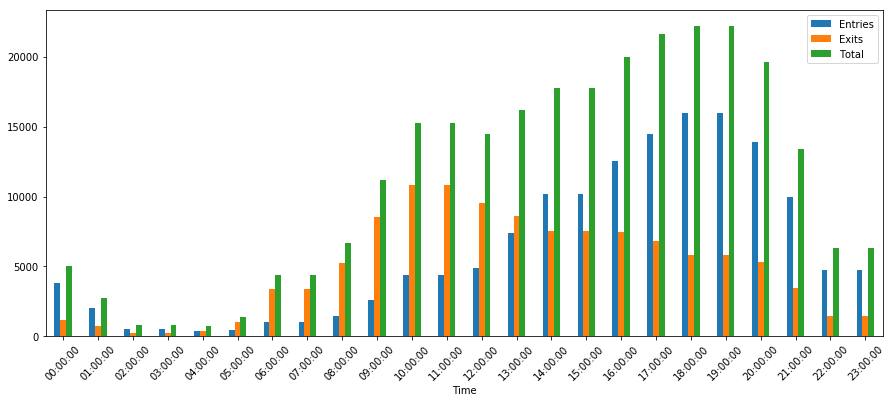

In [17]:
avg_usage_hourly.reset_index().sort_index(ascending = False).set_index('Time').plot(rot=45, figsize=(15,6), kind='bar')

# Visualization

### - Plot the daily row counts for data files in Q1 2013.

In [37]:
count = pd.read_sql_query("select Date, count(*) row_counts from delta  where Date between '2013-01-01' and '2013-03-31' group by Date", connex)

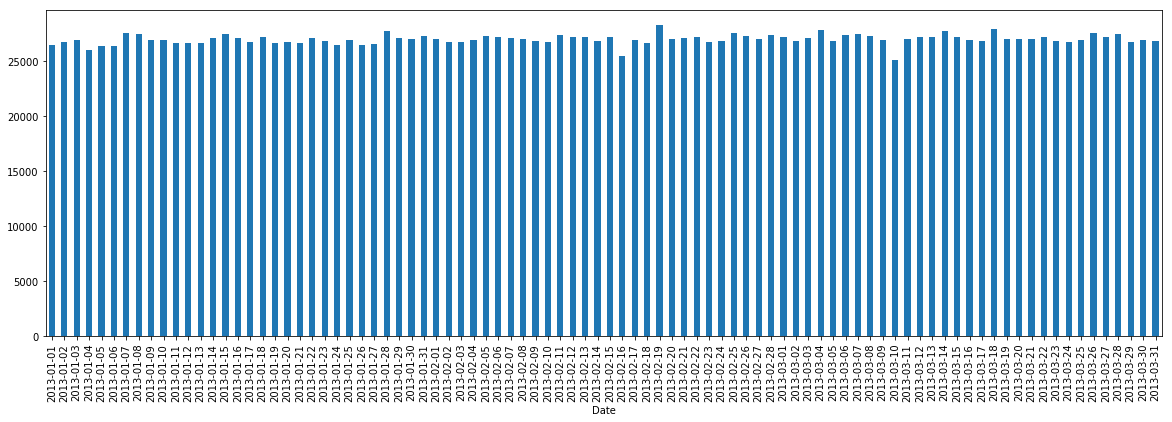

In [38]:
count.set_index('Date').plot(figsize=(20,6), kind='bar', fontsize=10, legend=False)

### - Plot the daily total number of entries & exits across the system for Q1 2013.

In [39]:
daily_2013Q1 = pd.read_sql_query("select Date, sum(Entries) Entries, sum(Exits) Exits  from delta  where Date between '2013-01-01' and '2013-03-31' group by Date", connex)

In [40]:
daily_2013Q1.set_index('Date',inplace=True)

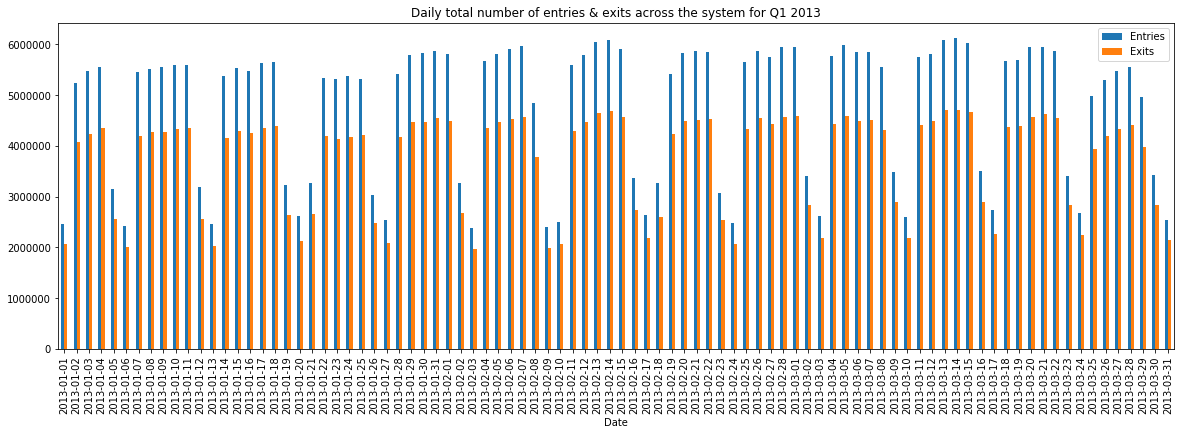

In [41]:
daily_2013Q1.plot(kind='bar', fontsize=10, figsize=(20,6), title='Daily total number of entries & exits across the system for Q1 2013')

### - Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.

In [42]:
penn_sta_2013Q1 = pd.read_sql_query("select Date, sum(Entries) Entries, sum(Exits) Exits  from delta  where Station = '34 ST-PENN STA' and Date between '2013-01-01' and '2013-03-31' group by Date", connex)

In [43]:
penn_sta_2013Q1['Month'] = penn_sta_2013Q1['Date'].str.slice(5,7)
group_monthly = penn_sta_2013Q1.groupby('Month')

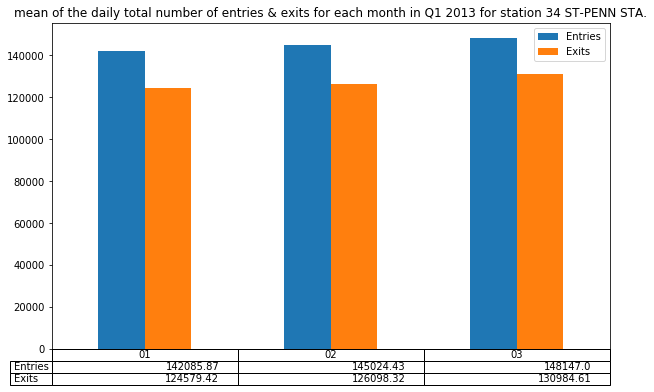

In [44]:
monthly_mean = group_monthly.mean()

fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False) 
monthly_mean.plot(ax=ax, use_index=True, kind='bar', table = np.round(monthly_mean.T, 2),figsize=(10,6),title='mean of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.')

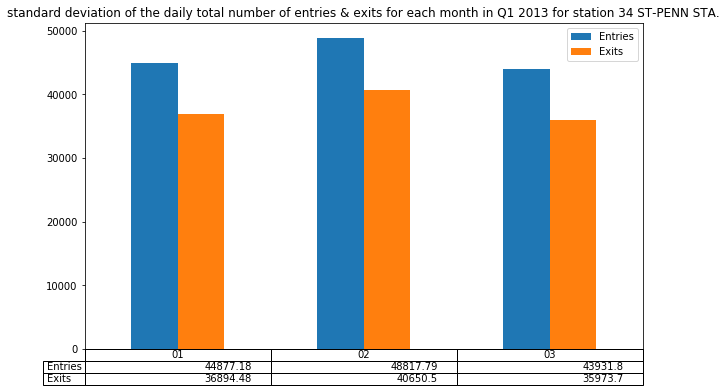

In [45]:
monthly_std = group_monthly.std()

fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False) 

monthly_std.plot(ax=ax, use_index=True, kind='bar', table = np.round(monthly_std.T, 2), figsize=(10,6),title='standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.')

### - Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.

In [46]:
percentile = group_monthly.describe().loc[:,list(zip(['Entries']*3+['Exits']*3,['25%', '50%', '75%']*2))]

In [47]:
percentile

Entries                        Exits                     
           25%       50%       75%      25%       50%        75%
Month                                                           
01     86212.5  170646.0  173188.0  81194.5  145841.0  151222.50
02     91983.0  176110.0  178376.5  84468.0  149998.0  154088.25
03     94980.0  175955.0  178862.5  92246.5  149133.0  155938.00

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000276D5907080>,
      dtype=object)

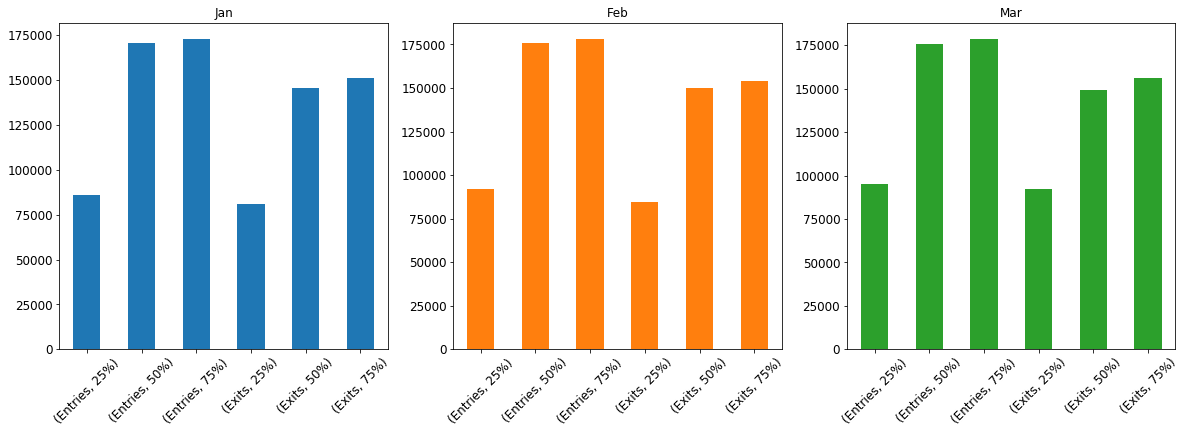

In [48]:
percentile.T.plot(kind='bar', rot=45, fontsize=12, figsize=(20,6), subplots=True, layout=(1,3), title=['Jan','Feb','Mar'],legend= False)

### - Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

In [51]:
closed_Q1 =  pd.read_sql_query("select distinct Date, Station from data  where Desc = 'DOOR CLOSE' and Date between '2013-01-01' and '2013-03-31' order by Date", connex).dropna()

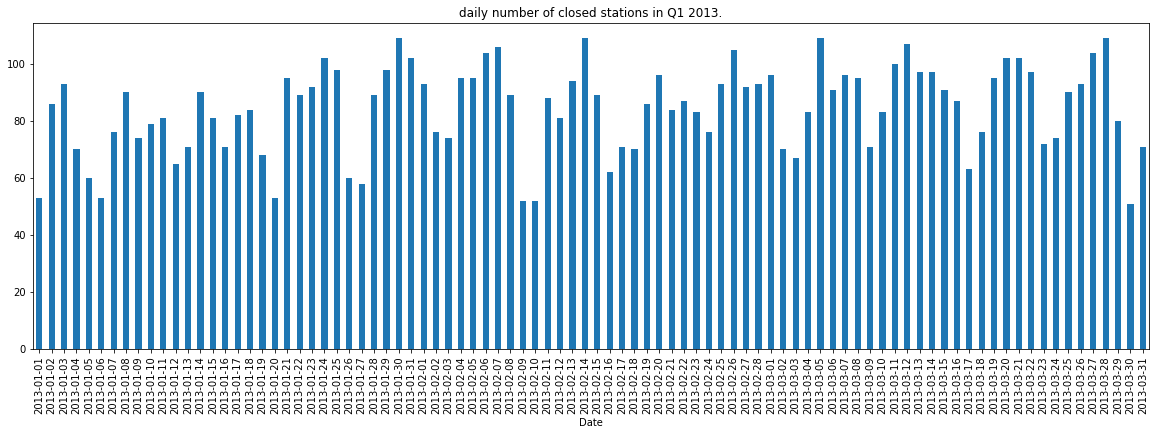

In [52]:
closed_Q1.groupby('Date').count().plot(kind='bar', figsize=(20,6),title='daily number of closed stations in Q1 2013.', legend=False)

In [ ]:
connex.close()